# 🧬 Chronic Kidney Disease (CKD) Prediction

This project aims to explore and model chronic kidney disease (CKD) progression using a synthetic but clinically realistic dataset.  
We will predict two binary targets:
- **CKD_Status**: Whether a patient has CKD.
- **Dialysis_Needed**: Whether a patient is likely to require dialysis.

The project includes EDA, feature analysis, binary classification modeling, and optional deployment for real-time predictions.


In [1]:
# Statistical tests
from scipy.stats import f_oneway

import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
import joblib

In [2]:
df = pd.read_csv('./dataset/kidney_disease_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               2304 non-null   int64  
 1   Creatinine_Level  2304 non-null   float64
 2   BUN               2304 non-null   float64
 3   Diabetes          2304 non-null   int64  
 4   Hypertension      2304 non-null   int64  
 5   GFR               2304 non-null   float64
 6   Urine_Output      2304 non-null   float64
 7   CKD_Status        2304 non-null   int64  
 8   Dialysis_Needed   2304 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 162.1 KB


In [4]:
df.head()

,Age,Creatinine_Level,BUN,Diabetes,Hypertension,GFR,Urine_Output,CKD_Status,Dialysis_Needed
0,71,0.30,40.9,0,1,46.8,1622.0,1,0
1,34,1.79,17.1,0,0,43.8,1428.0,1,0
2,80,2.67,15.0,0,1,78.2,1015.0,1,0
3,40,0.97,31.1,0,1,92.8,1276.0,1,0
4,43,2.05,22.8,1,1,62.2,1154.0,0,0


In [5]:
df.describe()

,Age,Creatinine_Level,BUN,Diabetes,Hypertension,GFR,Urine_Output,CKD_Status,Dialysis_Needed
count,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000
mean,54.159288,1.305638,18.813672,0.406684,0.498264,68.953863,1309.189670,0.508681,0.013455
std,20.513729,0.789594,10.508358,0.491322,0.500106,24.660191,491.951914,0.500033,0.115237
min,20.000000,0.300000,5.000000,0.000000,0.000000,5.000000,100.000000,0.000000,0.000000
25%,36.000000,0.620000,9.975000,0.000000,0.000000,51.300000,967.750000,0.000000,0.000000
50%,54.000000,1.240000,18.200000,0.000000,0.000000,69.150000,1295.500000,1.000000,0.000000
75%,72.000000,1.842500,26.000000,1.000000,1.000000,86.300000,1633.500000,1.000000,0.000000
max,90.000000,4.130000,61.900000,1.000000,1.000000,120.000000,2899.000000,1.000000,1.000000


In [6]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Age                 0
Creatinine_Level    0
BUN                 0
Diabetes            0
Hypertension        0
GFR                 0
Urine_Output        0
CKD_Status          0
Dialysis_Needed     0
dtype: int64


In [7]:
print("\nCKD_Status distribution:")
print(df["CKD_Status"].value_counts(normalize=True) * 100)

print("\nDialysis_Needed distribution:")
print(df["Dialysis_Needed"].value_counts(normalize=True) * 100)


CKD_Status distribution:
CKD_Status
1    50.868056
0    49.131944
Name: proportion, dtype: float64

Dialysis_Needed distribution:
Dialysis_Needed
0    98.654514
1     1.345486
Name: proportion, dtype: float64


## EDA

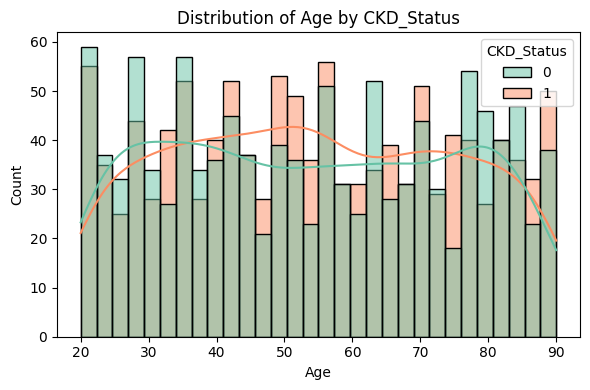

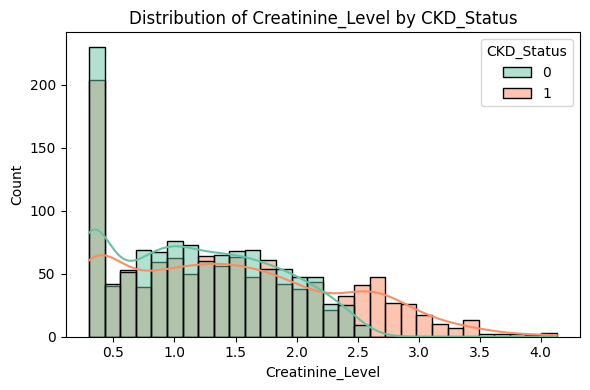

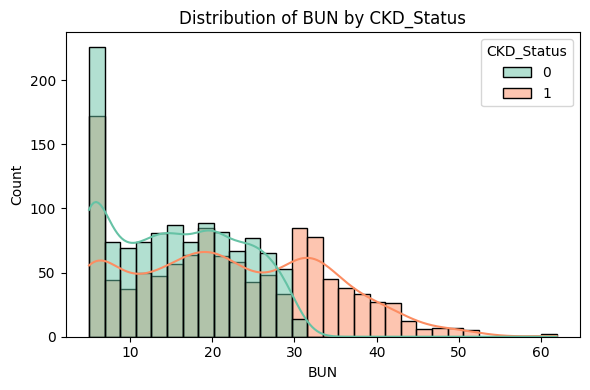

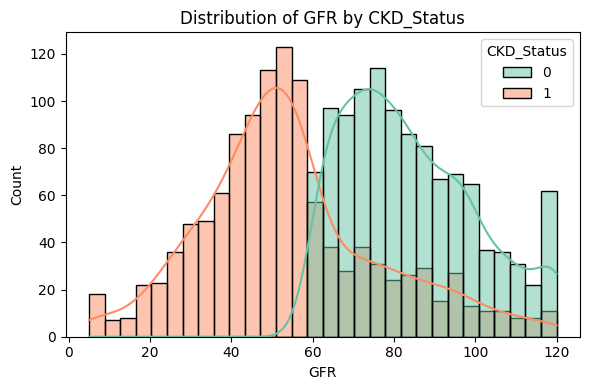

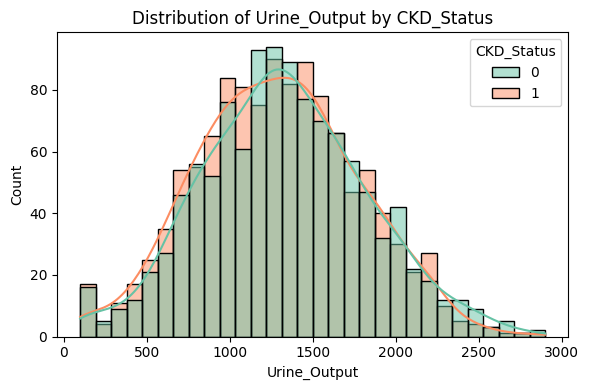

In [8]:
features = ["Age", "Creatinine_Level", "BUN", "GFR", "Urine_Output"]

for col in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, hue="CKD_Status", kde=True, palette="Set2", bins=30)
    plt.title(f"Distribution of {col} by CKD_Status")
    plt.tight_layout()
    plt.show()

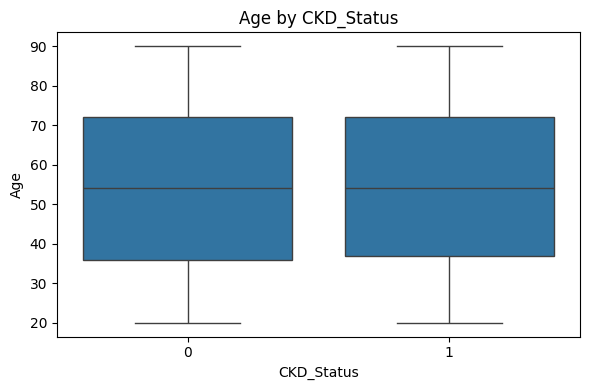

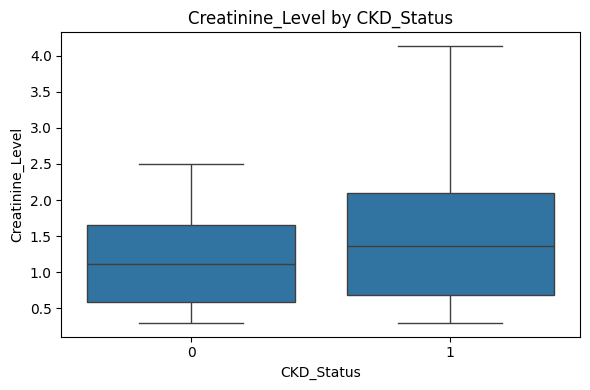

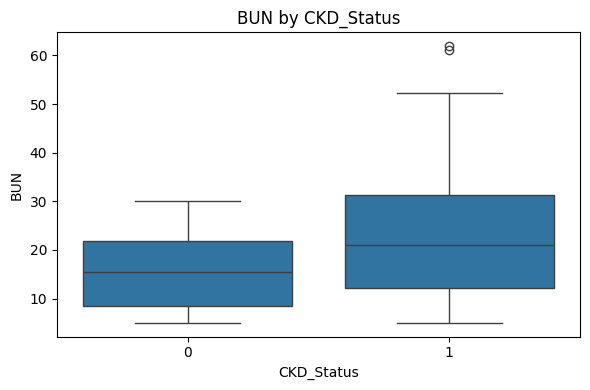

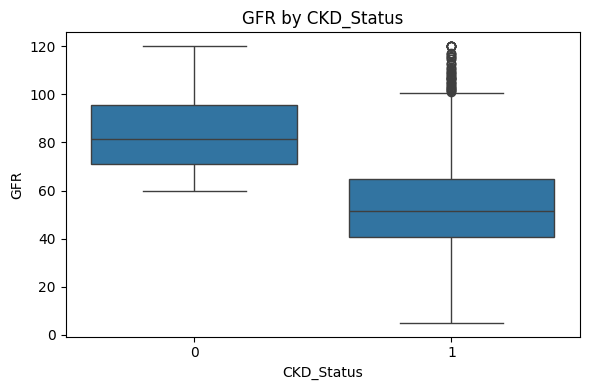

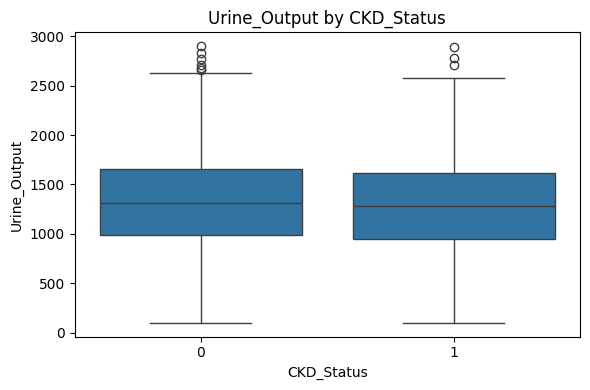

In [9]:
for col in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="CKD_Status", y=col, data=df)
    plt.title(f"{col} by CKD_Status")
    plt.tight_layout()
    plt.show()

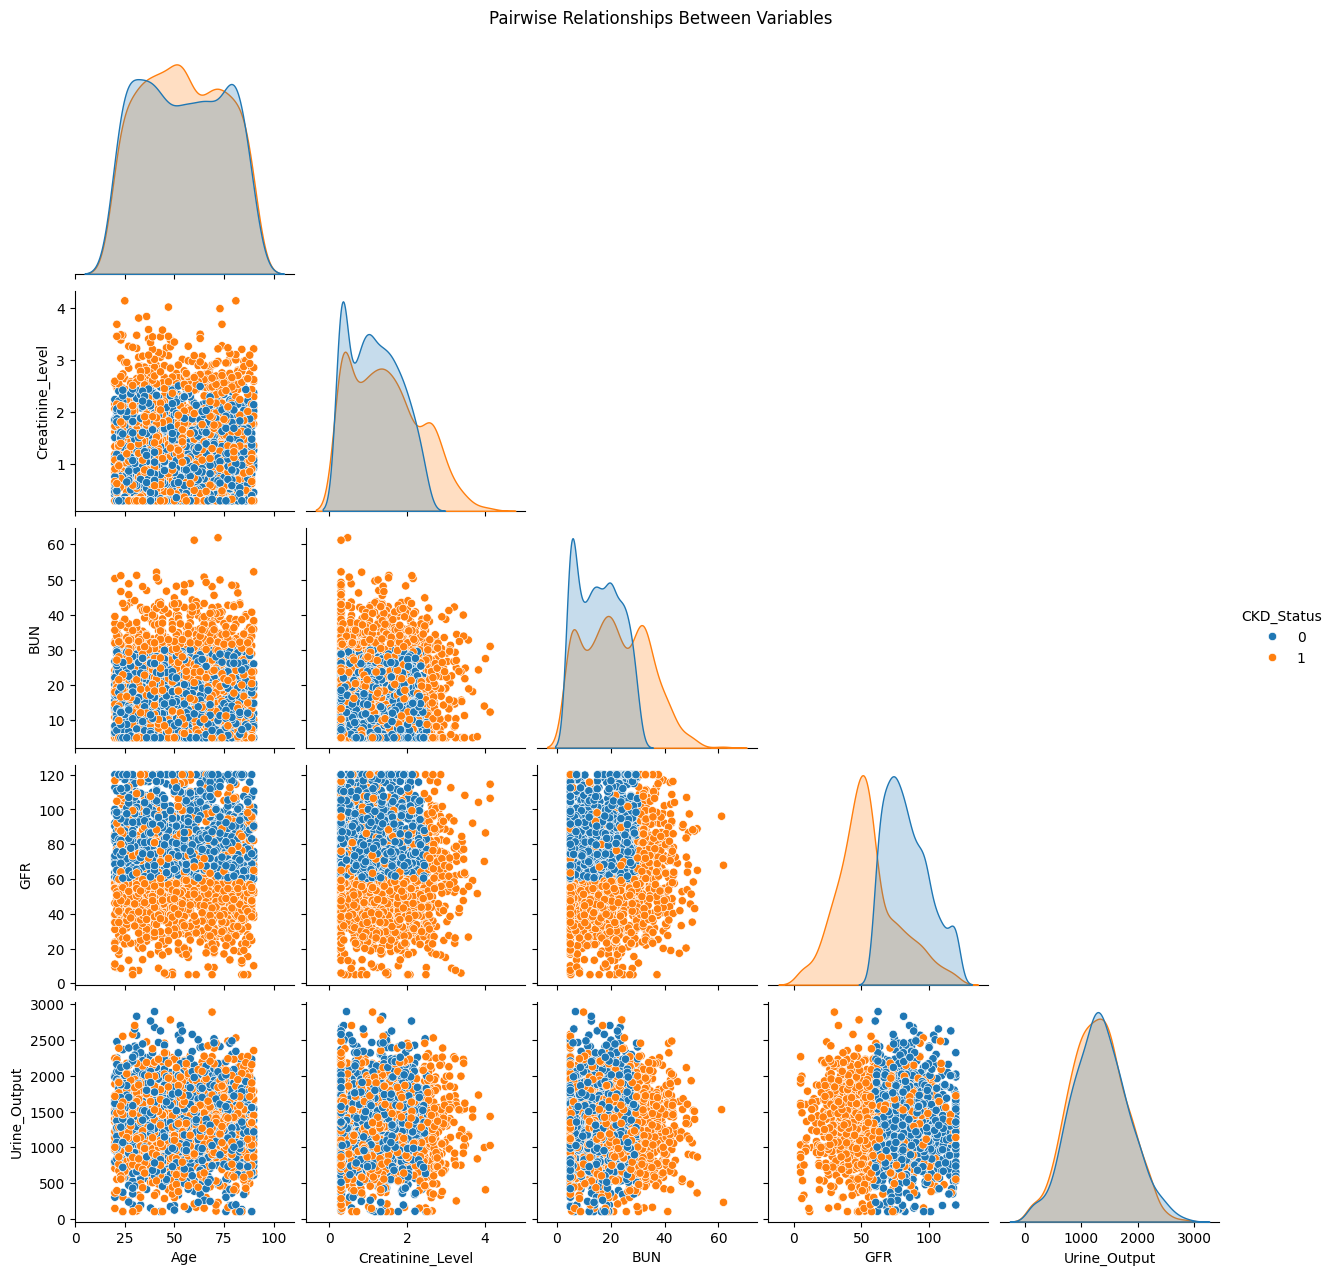

In [10]:
cols = ['Age',
 'Creatinine_Level',
 'BUN',
 'GFR',
 'Urine_Output',
 'CKD_Status']
sns.pairplot(df[cols], hue="CKD_Status", diag_kind="kde", corner=True)
plt.suptitle("Pairwise Relationships Between Variables", y=1.02)
plt.show()

In [11]:
numerics = df.select_dtypes(include=['float64', 'int64']).columns.difference(['Diabetes','CKD_Status',
 'Dialysis_Needed', 'Hypertension'])

results = []

for col in numerics:
    groups = [g[col].dropna().values for _, g in df.groupby("CKD_Status")]
    if all(len(g) > 1 for g in groups):
        f_val, p_val = f_oneway(*groups)
        results.append((col, round(f_val, 3), round(p_val, 5)))
        
pd.DataFrame(results, columns=["Variable", "F-statistic", "p-value"]).sort_values("p-value")

,Variable,F-statistic,p-value
1,BUN,237.481,0.00000
2,Creatinine_Level,81.594,0.00000
3,GFR,1306.200,0.00000
4,Urine_Output,3.991,0.04587
0,Age,0.355,0.55138


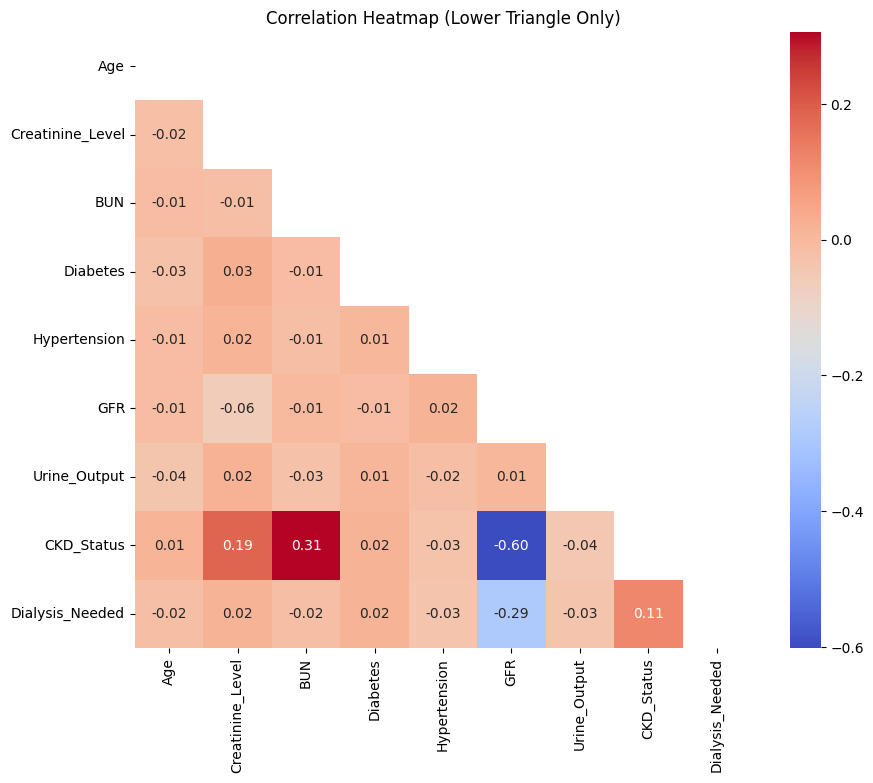

In [12]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap (Lower Triangle Only)")
plt.show()

In [13]:
X = df.drop(columns=["CKD_Status", "Dialysis_Needed"])  
y = df["CKD_Status"]

models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("KNN", KNeighborsClassifier()),
    ("XGBoost", XGBClassifier(eval_metric='logloss', random_state=42)
)
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="macro")

results = []

for name, model in models:
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", model)
    ])
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scorer)
    results.append({
        "Model": name,
        "F1_macro_Mean": np.round(scores.mean(), 4),
        "F1_macro_Std": np.round(scores.std(), 4)
    })
    
results_df = pd.DataFrame(results).sort_values("F1_macro_Mean", ascending=False)
print(results_df)

                 Model  F1_macro_Mean  F1_macro_Std
1        Random Forest         0.9996        0.0009
2    Gradient Boosting         0.9996        0.0009
4              XGBoost         0.9961        0.0040
3                  KNN         0.8919        0.0135
0  Logistic Regression         0.8337        0.0214


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model1 = RandomForestClassifier(random_state=42)
model1_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", model)
    ])
model1_pipeline.fit(X_train,y_train)

y_pred = model1_pipeline.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Confusion Matrix:
[[234   0]
 [  0 227]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       234
           1       1.00      1.00      1.00       227

    accuracy                           1.00       461
   macro avg       1.00      1.00      1.00       461
weighted avg       1.00      1.00      1.00       461



In [15]:
joblib.dump(model1_pipeline, "Rf_Model_CKD_Status.pkl")

['Rf_Model_CKD_Status.pkl']

In [16]:
X_dialysis = df.drop(columns=["CKD_Status", "Dialysis_Needed"])
y_dialysis = df["Dialysis_Needed"]

models_dialysis = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, class_weight="balanced")),
    ("Random Forest", RandomForestClassifier(random_state=42, class_weight="balanced")),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)), 
    ("KNN", KNeighborsClassifier()), 
    ("XGBoost", XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=(y_dialysis==0).sum()/(y_dialysis==1).sum()))
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="macro")

results_dialysis = []

for name, model in models_dialysis:
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", model)
    ])
    scores = cross_val_score(pipeline, X_dialysis, y_dialysis, cv=cv, scoring=scorer)
    results_dialysis.append({
        "Model": name,
        "F1_macro_Mean": np.round(scores.mean(), 4),
        "F1_macro_Std": np.round(scores.std(), 4)
    })

results_dialysis_df = pd.DataFrame(results_dialysis).sort_values("F1_macro_Mean", ascending=False)
print(results_dialysis_df)


                 Model  F1_macro_Mean  F1_macro_Std
1        Random Forest         0.9908        0.0184
2    Gradient Boosting         0.9830        0.0209
4              XGBoost         0.9762        0.0198
0  Logistic Regression         0.8385        0.0261
3                  KNN         0.4965        0.0003


In [17]:
X_dialysis_train, X_dialysis_test, y_dialysis_train, y_dialysis_test = train_test_split(X_dialysis, y_dialysis, test_size=0.2, random_state=42)

model2 = RandomForestClassifier(random_state=45, class_weight="balanced")
model2_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", model2)
    ])

model2_pipeline.fit(X_dialysis_train, y_dialysis_train)

y_pred = model2_pipeline.predict(X_dialysis_test)

from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_dialysis_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_dialysis_test, y_pred))


Confusion Matrix:
[[455   0]
 [  0   6]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       455
           1       1.00      1.00      1.00         6

    accuracy                           1.00       461
   macro avg       1.00      1.00      1.00       461
weighted avg       1.00      1.00      1.00       461



In [18]:
joblib.dump(model2_pipeline, "Rf_Model_Dialysis_Needed.pkl")

['Rf_Model_Dialysis_Needed.pkl']